In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install --upgrade --quiet  langchain langchain_experimental langchain-openai
!pip install --quiet datasets evaluate accelerate
# !pip install --quiet causal-conv1d>=1.1.0
# !pip install --quiet mamba-ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
id2label = {0: 'negative', 1: 'positive', 2: 'neutral'}
label2id = {'negative': 0, 'positive': 1, 'neutral': 2}

# Dataset
* Generate

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download yasserh/twitter-tweets-sentiment-dataset
! unzip twitter-tweets-sentiment-dataset.zip

 81% 1.00M/1.23M [00:00<00:00, 1.09MB/s]
100% 1.23M/1.23M [00:01<00:00, 1.28MB/s]
Archive:  twitter-tweets-sentiment-dataset.zip
  inflating: Tweets.csv              


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import random

In [ ]:
data=pd.read_csv("Tweets.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
data.groupby('sentiment').size()

sentiment
negative     7781
neutral     11118
positive     8582
dtype: int64

In [ ]:
seed = 42
n_minority=4500
n_majority=8000
sample_negative = data[data['sentiment'] == 'negative'].sample(n=n_minority, random_state=seed)
sample_positive = data[data['sentiment'] == 'positive'].sample(n=n_majority, random_state=seed)

negative_train, negative_test = train_test_split(sample_negative, test_size=1000/n_minority)
positive_train, positive_test = train_test_split(sample_positive, test_size=1000/n_majority)

train_data = pd.concat([negative_train, positive_train]).dropna()
test_data = pd.concat([negative_test, positive_test]).dropna()


In [ ]:
train_data.groupby('sentiment').size()

sentiment
negative    3500
positive    7000
dtype: int64

In [ ]:
test_data.groupby('sentiment').size()

sentiment
negative    1000
positive    1000
dtype: int64

In [ ]:
train_data['label'] = train_data['sentiment'].map(label2id)
test_data['label'] = test_data['sentiment'].map(label2id)

In [ ]:
train_data.groupby('label').size()

label
0    3500
1    7000
dtype: int64

In [ ]:
test_data.groupby('label').size()

label
0    1000
1    1000
dtype: int64

In [ ]:
# Save the CSV file to Google Drive
train_data.to_csv('imbalanced_train.csv')
test_data.to_csv('imbalanced_test.csv')
train_data.to_csv('/content/drive/My Drive/csi5386-project/imbalanced_train.csv')
test_data.to_csv('/content/drive/My Drive/csi5386-project/imbalanced_test.csv')

In [ ]:
train_dataset = Dataset.from_pandas(train_data.dropna())
test_dataset = Dataset.from_pandas(test_data.dropna())

random.seed(42)
total_samples = len(train_dataset)
eval_samples = int(0.2 * total_samples)
eval_indices = random.sample(range(total_samples), eval_samples)
eval_dataset = train_dataset.select(eval_indices)
train_indices = set(range(total_samples)) - set(eval_indices)
train_dataset = train_dataset.select(list(train_indices))

tweet = DatasetDict({
    'train': train_dataset.select_columns(['text', 'selected_text', 'label']),
    'eval': eval_dataset.select_columns(['text', 'selected_text', 'label']),
    'test': test_dataset.select_columns(['text', 'selected_text', 'label'])
})

In [ ]:
tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 8400
    })
    eval: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 2000
    })
})

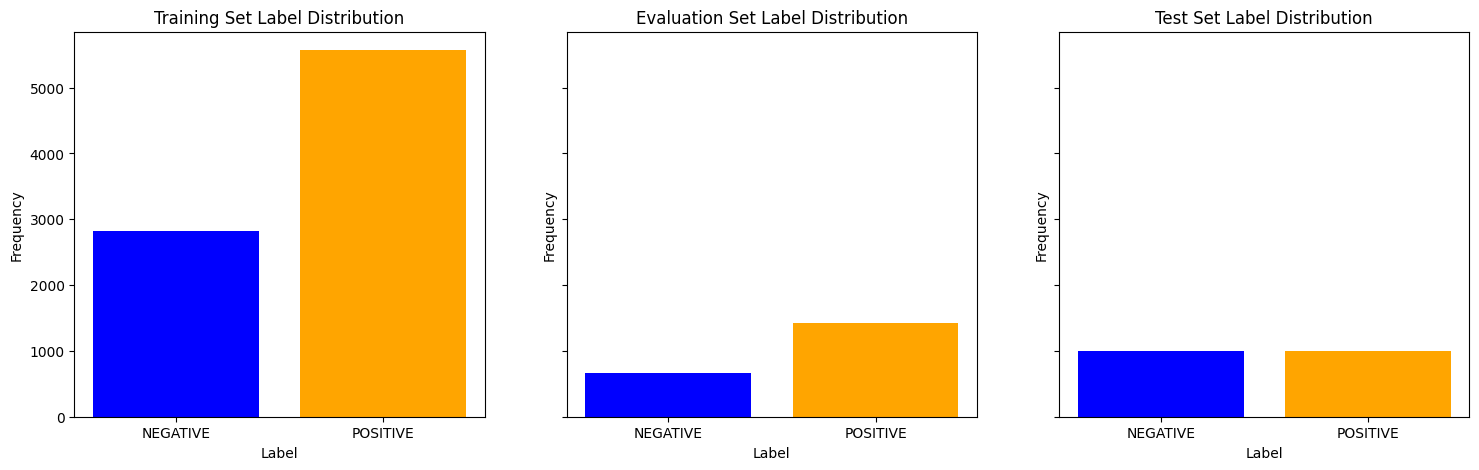

In [ ]:
from datasets import load_from_disk
tweet = load_from_disk('/content/drive/MyDrive/csi5386-project/dataset/imbalanced')
train_labels = np.array(tweet['train']['label'])
eval_labels = np.array(tweet['eval']['label'])
test_labels = np.array(tweet['test']['label'])

train_labels = np.vectorize(id2label.get)(train_labels)
eval_labels = np.vectorize(id2label.get)(eval_labels)
test_labels = np.vectorize(id2label.get)(test_labels)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

def plot_hist(data, ax, title):
    labels, counts = np.unique(data, return_counts=True)
    ax.bar(labels, counts, color=['blue', 'orange'], width=0.8)
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Frequency')
    ax.set_xticks(labels)

plot_hist(train_labels, axes[0], 'Training Set Label Distribution')
plot_hist(eval_labels, axes[1], 'Evaluation Set Label Distribution')
plot_hist(test_labels, axes[2], 'Test Set Label Distribution')

# plt.tight_layout()
# plt.show()
plt.savefig('/content/drive/MyDrive/csi5386-project/results/label_distribution.png',
            bbox_inches='tight')

In [ ]:
tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 8400
    })
    eval: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
# path_to_save = "/content/drive/MyDrive/csi5386-project/dataset/imbalanced"

# save DatasetDict to disk
# tweet.save_to_disk(path_to_save)

# load DatasetDict from disk
from datasets import load_from_disk
! cp -r /content/drive/MyDrive/csi5386-project/dataset/imbalanced .
tweet = load_from_disk('./imbalanced')
tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 8400
    })
    eval: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['text', 'selected_text', 'label'],
        num_rows: 2000
    })
})

# training on imbalanced data


## Mamba

In [ ]:
import os
import random
import json
import torch
import torch.nn as nn
from collections import namedtuple
from dataclasses import dataclass, field, asdict
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from mamba_ssm.utils.hf import load_config_hf, load_state_dict_hf

import evaluate
import numpy as np
from datasets import load_dataset, Dataset
from transformers import Trainer
from transformers import AutoTokenizer, TrainingArguments

ModuleNotFoundError: No module named 'mamba_ssm'

### Build Custom Mamba Model for Text Classification

In [ ]:
@dataclass
class MambaConfig:
    d_model: int = 768
    n_layer: int = 24
    vocab_size: int = 50254
    ssm_cfg: dict = field(default_factory=dict)
    rms_norm: bool = True
    residual_in_fp32: bool = True
    fused_add_norm: bool = True
    tie_embeddings: bool = True
    pad_vocab_size_multiple: int = 8
    num_classes = 2

    def to_json_string(self):
        return json.dumps(asdict(self))

    def to_dict(self):
        return asdict(self)

In [ ]:
class MambaClassificationHead(nn.Module):
    def __init__(self, d_model, num_classes, **kwargs):
        super(MambaClassificationHead, self).__init__()
        self.classification_head = nn.Linear(d_model, num_classes, **kwargs)

    def forward(self, hidden_states):
        return self.classification_head(hidden_states)

In [ ]:
class MambaTextClassification(MambaLMHeadModel):
    def __init__(
        self,
        config: MambaConfig,
        initializer_cfg=None,
        device=None,
        dtype=None,
    ) -> None:
        super().__init__(config, initializer_cfg, device, dtype)
        self.classification_head = MambaClassificationHead(d_model=config.d_model,
                                                           num_classes=config.num_classes)
        del self.lm_head

    def forward(self, input_ids, attention_mask=None, labels=None):
        hidden_states = self.backbone(input_ids)
        mean_hidden_states = hidden_states.mean(dim=1)
        logits = self.classification_head(mean_hidden_states)

        if labels is None:
          ClassificationOutput = namedtuple("ClassificationOutput", ["logits"])
          return ClassificationOutput(logits=logits)
        else:
          ClassificationOutput = namedtuple("ClassificationOutput", ["loss", "logits"])
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits, labels)

          return ClassificationOutput(loss=loss, logits=logits)

    def predict(self, text, tokenizer, id2label=None):
        input_ids = torch.tensor(tokenizer(text)['input_ids'], device='cuda')[None]
        with torch.no_grad():
          logits = self.forward(input_ids).logits[0]
          label = np.argmax(logits.cpu().numpy())

        if id2label is not None:
          return id2label[label]
        else:
          return label

    @classmethod
    def from_pretrained(cls, pretrained_model_name, device=None, dtype=None, **kwargs):
        config_data = load_config_hf(pretrained_model_name)
        config = MambaConfig(**config_data)
        model = cls(config, device=device, dtype=dtype, **kwargs)
        model_state_dict = load_state_dict_hf(pretrained_model_name, device=device, dtype=dtype)
        model.load_state_dict(model_state_dict, strict=False)
        print("Newly initialized embedding:", set(model.state_dict().keys()) - set(model_state_dict.keys()))
        return model

In [ ]:
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
model = MambaTextClassification.from_pretrained("state-spaces/mamba-130m")
# model = MambaLMHeadModel.from_pretrained("state-spaces/mamba-130m")
model.to("cuda")

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
tokenizer.pad_token_id = tokenizer.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/517M [00:00<?, ?B/s]

Newly initialized embedding: {'classification_head.classification_head.bias', 'classification_head.classification_head.weight'}


tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Preprocess dataset

In [ ]:
def preprocess_function(examples):
    samples = tokenizer(examples["text"], truncation=True)
    samples.pop('attention_mask')
    return samples

In [ ]:
tokenized_tweet = tweet.map(preprocess_function, batched=True)

Map:   0%|          | 0/8400 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'selected_text', 'label', 'input_ids'],
        num_rows: 8400
    })
    eval: Dataset({
        features: ['text', 'selected_text', 'label', 'input_ids'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['text', 'selected_text', 'label', 'input_ids'],
        num_rows: 2000
    })
})

In [ ]:
train_dataset = tokenized_tweet["train"]
eval_dataset = tokenized_tweet["eval"]
test_dataset = tokenized_tweet["test"]

### Evaluation metric

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Training

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
class MambaTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        input_ids = inputs.pop("input_ids")
        input_ids = input_ids.to(self.args.device)
        labels = inputs.pop('labels')
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

    def save_model(self, output_dir = None, _internal_call = False):
        if output_dir is None:
            output_dir = self.args.output_dir

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        torch.save(self.model.state_dict(), f"{output_dir}/pytorch_model.bin")

        self.tokenizer.save_pretrained(output_dir)

        with open(f'{output_dir}/config.json', 'w') as f:
            json.dump(self.model.config.to_dict(), f)

In [ ]:
training_args = TrainingArguments(
    output_dir="imbalanced_mamba",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    warmup_ratio=0.01,
    lr_scheduler_type="cosine",
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    logging_strategy="steps",
    logging_steps=1,
    push_to_hub=True,
    load_best_model_at_end=True,
)

In [ ]:
trainer = MambaTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics
    )

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
420,0.243900,0.325538,0.897619
840,0.355500,0.261453,0.910952
1260,0.006900,0.273392,0.923333
1680,1.639200,0.293550,0.927143
2100,0.000100,0.250584,0.926667
2520,0.002000,0.319426,0.928571
2940,0.000000,0.327446,0.927619
3360,0.000000,0.345510,0.930952
3780,0.000000,0.340044,0.930476
4200,0.797500,0.338608,0.930952


TrainOutput(global_step=4200, training_loss=0.22696283817263282, metrics={'train_runtime': 454.3036, 'train_samples_per_second': 36.98, 'train_steps_per_second': 9.245, 'total_flos': 0.0, 'train_loss': 0.22696283817263282, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

CommitInfo(commit_url='https://huggingface.co/erostrate9/imbalanced_mamba/commit/95c2097b9114ce00ec4f262729c10b87c557c085', commit_message='Training complete', commit_description='', oid='95c2097b9114ce00ec4f262729c10b87c557c085', pr_url=None, pr_revision=None, pr_num=None)

### Testing

In [ ]:
def save_outputs(trainer, test_dataset, saving_path):
    outputs = trainer.predict(test_dataset)
    y_pred = np.argmax(outputs.predictions, axis=1)
    y_true = outputs.label_ids
    if not os.path.exists(saving_path):
        os.makedirs(saving_path)
    np.save(saving_path+'predictions.npy', outputs.predictions)
    np.save(saving_path+'y_pred.npy', y_pred)
    np.save(saving_path+'y_true.npy', y_true)
    return outputs, y_pred, y_true

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/mamba_imbalanced/'
outputs, y_pred, y_true = save_outputs(trainer, test_dataset, saving_path = saving_path)
outputs

PredictionOutput(predictions=array([[ 5.670784 , -4.9513364],
       [ 2.8957865, -2.5303714],
       [ 3.260234 , -2.2747693],
       ...,
       [-7.1037364,  5.7547097],
       [-4.3359556,  3.9087288],
       [-3.1341128,  3.2671483]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.3095948100090027, 'test_accuracy': 0.9275, 'test_runtime': 3.2075, 'test_samples_per_second': 623.546, 'test_steps_per_second': 38.972})

In [ ]:
predictions = np.load('/content/drive/MyDrive/csi5386-project/results/mamba_imbalanced/predictions.npy')
y_pred = np.load('/content/drive/MyDrive/csi5386-project/results/mamba_imbalanced/y_pred.npy')
y_true = np.load('/content/drive/MyDrive/csi5386-project/results/mamba_imbalanced/y_true.npy')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os

def compute_metrics(predictions, references):
    clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
    return clf_metrics.compute(predictions=predictions, references=references)

def plot_confusion_matrix(y_true, y_pred, id2label, saving_path='confusion_matrix.png'):
    dir = os.path.dirname(saving_path)
    if not os.path.exists(dir):
        os.makedirs(dir)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(saving_path)
    return cm

def plot_roc_curve(labels, predictions, saving_path='roc_curve.png'):
    dir = os.path.dirname(saving_path)
    if not os.path.exists(dir):
        os.makedirs(dir)
    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(saving_path)

(906, 94, 51, 949)

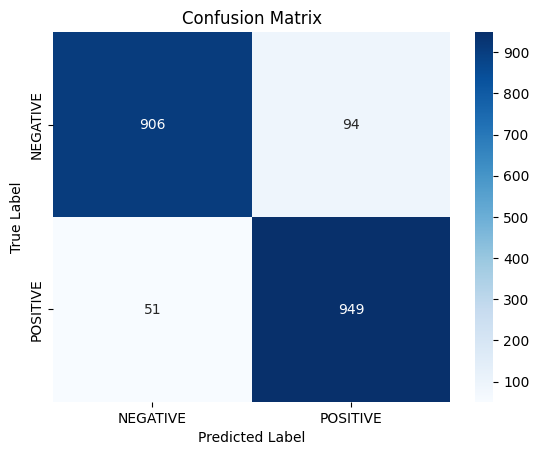

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/mamba_imbalanced/confusion_matrix.png'
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
cm = plot_confusion_matrix(y_true, y_pred, id2label, saving_path)
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

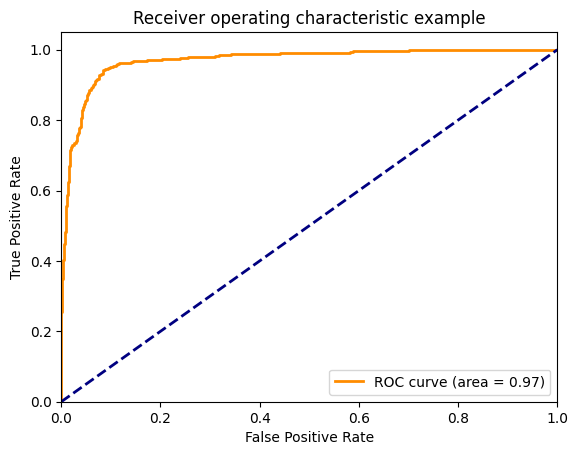

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/mamba_imbalanced/roc.curve.png'
plot_roc_curve(y_true, predictions, saving_path=saving_path)

In [ ]:
compute_metrics(y_pred, y_true)

{'accuracy': 0.9275,
 'f1': 0.9290259422418014,
 'precision': 0.909875359539789,
 'recall': 0.949}

## DistillBERT

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_tweet = tweet.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8400 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_tweet["train"]
eval_dataset = tokenized_tweet["eval"]
test_dataset = tokenized_tweet["test"]

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="distillbert_imbalanced",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    warmup_ratio=0.01,
    lr_scheduler_type="cosine",
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    logging_strategy="steps",
    logging_steps=1,
    push_to_hub=True,
    load_best_model_at_end=True,
)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
420,0.192200,0.255343,0.922381
840,2.582400,0.421414,0.902381
1260,0.017400,0.274029,0.926190
1680,0.094000,0.348117,0.919524
2100,0.003200,0.304943,0.931905
2520,0.002600,0.318772,0.930952
2940,0.000700,0.328075,0.929524
3360,0.000800,0.342727,0.930476
3780,0.007000,0.343516,0.931905
4200,0.002900,0.346190,0.931905


TrainOutput(global_step=4200, training_loss=0.25530977459613324, metrics={'train_runtime': 140.9573, 'train_samples_per_second': 119.185, 'train_steps_per_second': 29.796, 'total_flos': 137519788032864.0, 'train_loss': 0.25530977459613324, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

CommitInfo(commit_url='https://huggingface.co/erostrate9/distillbert_imbalanced/commit/dbc2562e12923c29639b76d072289143b79b9a0e', commit_message='Training complete', commit_description='', oid='dbc2562e12923c29639b76d072289143b79b9a0e', pr_url=None, pr_revision=None, pr_num=None)

### Testing

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/distillbert_imbalanced/'
outputs, y_pred, y_true = save_outputs(trainer, test_dataset, saving_path = saving_path)
outputs

PredictionOutput(predictions=array([[ 1.8897064 , -1.6371721 ],
       [ 0.84222215, -0.689308  ],
       [ 1.3949889 , -1.356257  ],
       ...,
       [-2.7116377 ,  3.5375397 ],
       [-2.669702  ,  3.453371  ],
       [-2.5171933 ,  3.2856789 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.31693702936172485, 'test_accuracy': 0.907, 'test_runtime': 1.0103, 'test_samples_per_second': 1979.662, 'test_steps_per_second': 123.729})

(876, 124, 62, 938)

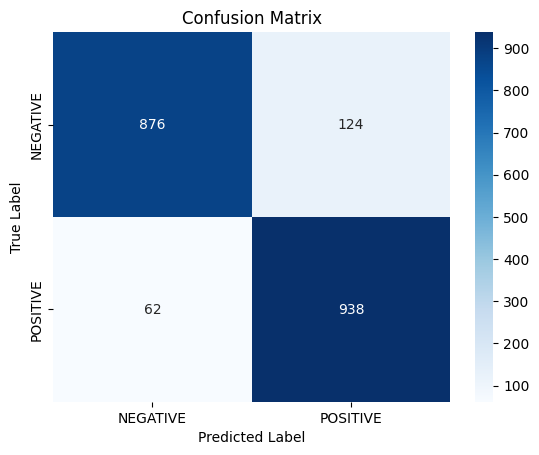

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/distillbert_imbalanced/confusion_matrix.png'
cm = plot_confusion_matrix(y_true, y_pred, id2label, saving_path)
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

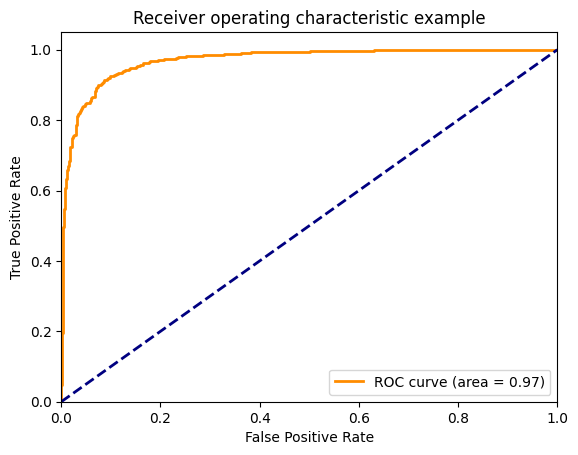

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/distillbert_imbalanced/roc.curve.png'
plot_roc_curve(y_true, outputs.predictions, saving_path=saving_path)

In [ ]:
compute_metrics(y_pred, y_true)

{'accuracy': 0.907,
 'f1': 0.909796314258002,
 'precision': 0.8832391713747646,
 'recall': 0.938}

In [ ]:
# ! mkdir /content/drive/MyDrive/csi5386-project/results/mamba_imbalanced
! cp -r results/mamba_imbalanced /content/drive/MyDrive/csi5386-project/results/

## Naive Bayes

In [ ]:
! cp -r '/content/drive/MyDrive/csi5386-project/dataset/imbalanced' .

from datasets import load_from_disk
import pandas as pd
from datasets import Dataset, concatenate_datasets, DatasetDict
import numpy as np
import matplotlib.pyplot as plt

id2label = {0: 'NEGATIVE', 1: 'POSITIVE'}

tweet = load_from_disk('./imbalanced')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,  ConfusionMatrixDisplay

X_train = tweet['train']['text']
X_test = tweet['test']['text']
y_train = tweet['train']['label']
y_test = tweet['test']['label']

pipe = Pipeline([('tfidf_vectorizer',TfidfVectorizer(lowercase = True,
                                                     stop_words = 'english',
                                                    analyzer = 'word')),

                 ('naive_bayes', MultinomialNB())])


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

pipe.fit(list(X_train), list(y_train))
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_pred, y_test))
pipe['naive_bayes']

[[416  20]
 [584 980]]
0.698


MultinomialNB()

(416, 584, 20, 980)

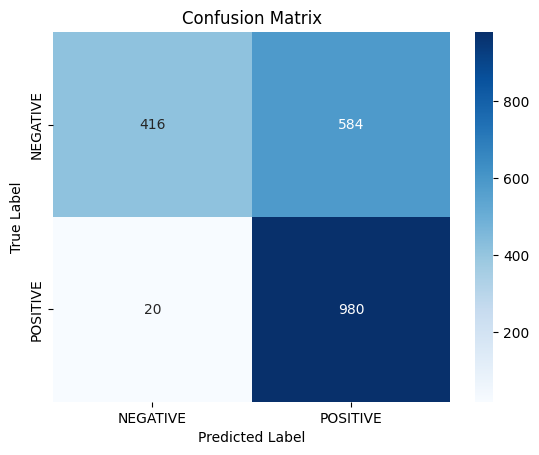

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/naive_bayes_imbalanced/confusion_matrix.png'
cm = plot_confusion_matrix(y_test, y_pred, id2label, saving_path)
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

In [ ]:
compute_metrics(y_pred, y_test)

{'accuracy': 0.698,
 'f1': 0.764430577223089,
 'precision': 0.6265984654731458,
 'recall': 0.98}

# Augmented data

## Data Augmentation

In [ ]:
tweet['train']

Dataset({
    features: ['text', 'selected_text', 'label'],
    num_rows: 8400
})

In [ ]:
negative_data = tweet['train'].filter(lambda example: example['label'] == 0)
positive_data = tweet['train'].filter(lambda example: example['label'] == 1)
print(len(negative_data))
print(len(positive_data))

2829
5571


In [ ]:
import os
os.environ["OPENAI_API_KEY"] =  'OPENAI_API_KEY'

In [ ]:

from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_experimental.tabular_synthetic_data.openai import (
    OPENAI_TEMPLATE,
    create_openai_data_generator,
)
from langchain_experimental.tabular_synthetic_data.prompts import (
    SYNTHETIC_FEW_SHOT_PREFIX,
    SYNTHETIC_FEW_SHOT_SUFFIX,
)
from langchain_openai import ChatOpenAI

In [ ]:
negative_eval = tweet['eval'].filter(lambda example: example['label'] == 0)

Filter:   0%|          | 0/2100 [00:00<?, ? examples/s]

In [ ]:
negative_eval[:6]

{'text': [' waaaaayyyyy too hot for that',
  '_ I don`t see how there could possibly be another choice.',
  'Off to meeting in Lincoln Square, bummer, no more free parking',
  'Ooh hayfever has struck..thought I was going to avoid it this year but nooo!  Remedies anyone...?',
  'I miss ya, Boyfriend!  When am I gonna see ya again? Br!Tt!!!',
  'is really ultra bored'],
 'selected_text': ['too hot',
  'I don`t see how there could possibly be another choice.',
  'bummer,',
  'hayfever has struck..',
  'miss',
  'bored'],
 'label': [0, 0, 0, 0, 0, 0]}

In [ ]:
examples = [
    {
        "example": """Text:  waaaaayyyyy too hot for that,
        Selected Text: too hot,
        Sentiment: NEGATIVE"""
    },
    {
        "example": """Text:  _ I don`t see how there could possibly be another choice.,
        Selected Text: I don`t see how there could possibly be another choice.,
        Sentiment: NEGATIVE"""
    },
    {
        "example": """Text:  Off to meeting in Lincoln Square, bummer, no more free parking,
        Selected Text: bummer,
        Sentiment: NEGATIVE"""
    },
    {
        "example": """Text:  Ooh hayfever has struck..thought I was going to avoid it this year but nooo!  Remedies anyone...?,
        Selected Text: hayfever has struck..,
        Sentiment: NEGATIVE"""
    },
    {
        "example": """Text:  is really ultra bored,
        Selected Text: bored,
        Sentiment: NEGATIVE"""
    },
]

In [ ]:
tweet_schema = {
    "type": "object",
    "properties": {
        "text": {
            "type": "string",
            "description": "The content of the tweet."
        },
        "selected_text": {
            "type": "string",
            "description": "All substrings of the text that express its sentiment."
        },
        "sentiment": {
            "type": "string",
            "description": "The sentiment expressed in the text.",
            "enum": ["positive", "negative"]
        }
    },
    "required": ["text", "selected_text", "sentiment"]
}

OPENAI_TEMPLATE = PromptTemplate(input_variables=["example"], template="{example}")

prompt_template = FewShotPromptTemplate(
    prefix=SYNTHETIC_FEW_SHOT_PREFIX,
    examples=examples,
    suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
    input_variables=["subject", "extra"],
    example_prompt=OPENAI_TEMPLATE,
)

def generate_synthetic_data(output_schema, subject, extra):
    synthetic_data_generator = create_openai_data_generator(
        output_schema=output_schema,
        llm=ChatOpenAI(
            model_name="gpt-3.5-turbo",
            temperature=1
        ),
        prompt=prompt_template,
    )
    result = synthetic_data_generator.generate(
      subject=subject,
      extra=extra,
      runs=1
    )
    return result


In [ ]:
import pandas as pd
subject = 'negative_tweet'
augmented_num = len(positive_data['text']) - len(negative_data['text']) # 2742
print('augmented_num: ', augmented_num)
synthetic_results = []
save_step = 100
save_path = f'/content/drive/MyDrive/csi5386-project/dataset/synthetic_results.csv'
df = None
for i, text in enumerate(negative_data['text'][:augmented_num]):
    extra = f'REFERENCE:{text}. text is a paraphrase of the given REFERENCE. Sentiment of text must be negative. Do not alter the style of the REFERENCE. Do not add extra information. Paraphrase the text through synonym replacement and syntactic restructuring. selected_text should contain all substrings of generated text that reflects negative sentiment.'
    result = generate_synthetic_data(tweet_schema, subject, extra)
    synthetic_results.append(result[0])
    if (i%save_step==0 or i==augmented_num-1):
      df = pd.DataFrame(synthetic_results)
      df.to_csv(save_path)
      print(f'Augmented {i+1}/{augmented_num} rows.')
df

augmented_num:  2742
Augmented 0/2742 rows.
Augmented 100/2742 rows.
Augmented 200/2742 rows.


In [ ]:
! cp -r '/content/drive/MyDrive/csi5386-project/dataset/imbalanced' .
! cp '/content/drive/MyDrive/csi5386-project/dataset/synthetic_results.csv' .

In [ ]:
from datasets import load_from_disk
import pandas as pd
from datasets import Dataset, concatenate_datasets, DatasetDict

tweet = load_from_disk('./imbalanced')
negative_data = tweet['train'].filter(lambda x: x['label'] == 0)
positive_data = tweet['train'].filter(lambda x: x['label'] == 1)
n_negative = len(negative_data['text'])
n_positive = len(positive_data['text'])
df_augmented_train = pd.read_csv('synthetic_results.csv')
df_augmented_train['label'] = 0
synthetic_dataset = Dataset.from_pandas(df_augmented_train).select_columns(['text', 'selected_text','label']).select(range(n_positive-n_negative))
augmented_train_dataset = concatenate_datasets([tweet['train'], synthetic_dataset])

augmented_tweet = DatasetDict({
    'train': augmented_train_dataset.select_columns(['text', 'selected_text','label']),
    'eval': tweet['eval'],
    'test': tweet['test']
})
augmented_tweet

## Visualization

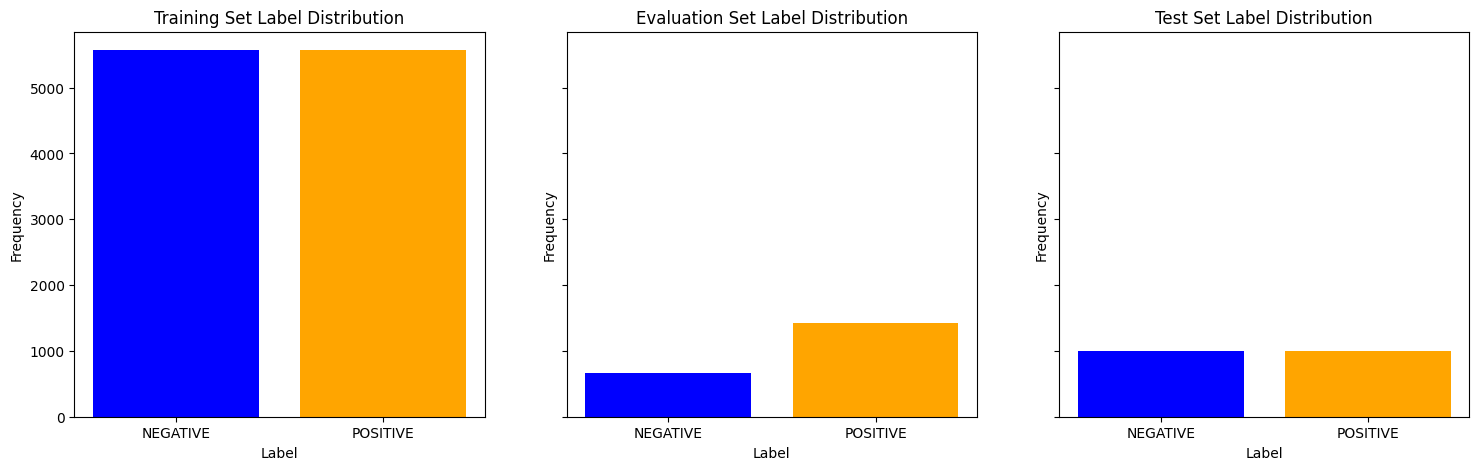

In [ ]:
! cp -r '/content/drive/MyDrive/csi5386-project/dataset/augmented' .

from datasets import load_from_disk
import pandas as pd
from datasets import Dataset, concatenate_datasets, DatasetDict
import numpy as np
import matplotlib.pyplot as plt

id2label = {0: 'NEGATIVE', 1: 'POSITIVE'}

augmented_tweet = load_from_disk('./augmented')
train_labels = np.array(augmented_tweet['train']['label'])
eval_labels = np.array(augmented_tweet['eval']['label'])
test_labels = np.array(augmented_tweet['test']['label'])

train_labels = np.vectorize(id2label.get)(train_labels)
eval_labels = np.vectorize(id2label.get)(eval_labels)
test_labels = np.vectorize(id2label.get)(test_labels)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

def plot_hist(data, ax, title):
    labels, counts = np.unique(data, return_counts=True)
    ax.bar(labels, counts, color=['blue', 'orange'], width=0.8)
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Frequency')
    ax.set_xticks(labels)

plot_hist(train_labels, axes[0], 'Training Set Label Distribution')
plot_hist(eval_labels, axes[1], 'Evaluation Set Label Distribution')
plot_hist(test_labels, axes[2], 'Test Set Label Distribution')

plt.savefig('/content/drive/MyDrive/csi5386-project/results/augmented_label_distribution.png',
            bbox_inches='tight')

## Mamba

In [ ]:
import os
import random
import json
import torch
import torch.nn as nn
from collections import namedtuple
from dataclasses import dataclass, field, asdict
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from mamba_ssm.utils.hf import load_config_hf, load_state_dict_hf

import evaluate
import numpy as np
from datasets import load_dataset, Dataset
from transformers import Trainer
from transformers import AutoTokenizer, TrainingArguments

### Build Custom Mamba Model for Text Classification

In [ ]:
@dataclass
class MambaConfig:
    d_model: int = 768
    n_layer: int = 24
    vocab_size: int = 50254
    ssm_cfg: dict = field(default_factory=dict)
    rms_norm: bool = True
    residual_in_fp32: bool = True
    fused_add_norm: bool = True
    tie_embeddings: bool = True
    pad_vocab_size_multiple: int = 8
    num_classes = 2

    def to_json_string(self):
        return json.dumps(asdict(self))

    def to_dict(self):
        return asdict(self)

In [ ]:
class MambaClassificationHead(nn.Module):
    def __init__(self, d_model, num_classes, **kwargs):
        super(MambaClassificationHead, self).__init__()
        self.classification_head = nn.Linear(d_model, num_classes, **kwargs)

    def forward(self, hidden_states):
        return self.classification_head(hidden_states)

In [ ]:
class MambaTextClassification(MambaLMHeadModel):
    def __init__(
        self,
        config: MambaConfig,
        initializer_cfg=None,
        device=None,
        dtype=None,
    ) -> None:
        super().__init__(config, initializer_cfg, device, dtype)
        self.classification_head = MambaClassificationHead(d_model=config.d_model,
                                                           num_classes=config.num_classes)
        del self.lm_head

    def forward(self, input_ids, attention_mask=None, labels=None):
        hidden_states = self.backbone(input_ids)
        mean_hidden_states = hidden_states.mean(dim=1)
        logits = self.classification_head(mean_hidden_states)

        if labels is None:
          ClassificationOutput = namedtuple("ClassificationOutput", ["logits"])
          return ClassificationOutput(logits=logits)
        else:
          ClassificationOutput = namedtuple("ClassificationOutput", ["loss", "logits"])
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits, labels)

          return ClassificationOutput(loss=loss, logits=logits)

    def predict(self, text, tokenizer, id2label=None):
        input_ids = torch.tensor(tokenizer(text)['input_ids'], device='cuda')[None]
        with torch.no_grad():
          logits = self.forward(input_ids).logits[0]
          label = np.argmax(logits.cpu().numpy())

        if id2label is not None:
          return id2label[label]
        else:
          return label

    @classmethod
    def from_pretrained(cls, pretrained_model_name, device=None, dtype=None, **kwargs):
        config_data = load_config_hf(pretrained_model_name)
        config = MambaConfig(**config_data)
        model = cls(config, device=device, dtype=dtype, **kwargs)
        model_state_dict = load_state_dict_hf(pretrained_model_name, device=device, dtype=dtype)
        model.load_state_dict(model_state_dict, strict=False)
        print("Newly initialized embedding:", set(model.state_dict().keys()) - set(model_state_dict.keys()))
        return model

In [ ]:
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
model = MambaTextClassification.from_pretrained("state-spaces/mamba-130m")
# model = MambaLMHeadModel.from_pretrained("state-spaces/mamba-130m")
model.to("cuda")

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
tokenizer.pad_token_id = tokenizer.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/517M [00:00<?, ?B/s]

Newly initialized embedding: {'classification_head.classification_head.bias', 'classification_head.classification_head.weight'}


tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Preprocess dataset

In [ ]:
def preprocess_function(examples):
    samples = tokenizer(examples["text"], truncation=True)
    samples.pop('attention_mask')
    return samples

In [ ]:
tokenized_tweet = augmented_tweet.map(preprocess_function, batched=True)

Map:   0%|          | 0/11142 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'selected_text', 'label', 'input_ids'],
        num_rows: 11142
    })
    eval: Dataset({
        features: ['text', 'selected_text', 'label', 'input_ids'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['text', 'selected_text', 'label', 'input_ids'],
        num_rows: 2000
    })
})

In [ ]:
train_dataset = tokenized_tweet["train"]
eval_dataset = tokenized_tweet["eval"]
test_dataset = tokenized_tweet["test"]

### Evaluation metric

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Training

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
class MambaTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        input_ids = inputs.pop("input_ids")
        input_ids = input_ids.to(self.args.device)
        labels = inputs.pop('labels')
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

    def save_model(self, output_dir = None, _internal_call = False):
        if output_dir is None:
            output_dir = self.args.output_dir

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        torch.save(self.model.state_dict(), f"{output_dir}/pytorch_model.bin")

        self.tokenizer.save_pretrained(output_dir)

        with open(f'{output_dir}/config.json', 'w') as f:
            json.dump(self.model.config.to_dict(), f)

In [ ]:
training_args = TrainingArguments(
    output_dir="augmented_mamba",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    warmup_ratio=0.01,
    lr_scheduler_type="cosine",
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    logging_strategy="steps",
    logging_steps=1,
    push_to_hub=True,
    load_best_model_at_end=True,
)

In [ ]:
trainer = MambaTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics
    )

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
558,0.074100,0.356060,0.894286
1116,0.003600,0.314775,0.909048
1674,0.000100,0.402644,0.920000
2232,0.000600,0.282945,0.925714
2790,0.003000,0.332972,0.920952
3348,0.000800,0.401495,0.923810
3906,0.000200,0.454407,0.920952
4464,0.001200,0.406157,0.926190
5022,1.626400,0.399116,0.923333


TrainOutput(global_step=5572, training_loss=0.185304711870447, metrics={'train_runtime': 602.7182, 'train_samples_per_second': 36.972, 'train_steps_per_second': 9.245, 'total_flos': 0.0, 'train_loss': 0.185304711870447, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

CommitInfo(commit_url='https://huggingface.co/erostrate9/augmented_mamba/commit/e97d2ca7dd378ce9b28ccab8ac2bff463c3d7b91', commit_message='Training complete', commit_description='', oid='e97d2ca7dd378ce9b28ccab8ac2bff463c3d7b91', pr_url=None, pr_revision=None, pr_num=None)

### Testing

In [ ]:
predictions = np.load('/content/drive/MyDrive/csi5386-project/results/mamba_augmented/predictions.npy')
y_pred = np.load('/content/drive/MyDrive/csi5386-project/results/mamba_augmented/y_pred.npy')
y_true = np.load('/content/drive/MyDrive/csi5386-project/results/mamba_augmented/y_true.npy')

In [ ]:
def save_outputs(trainer, test_dataset, saving_path):
    outputs = trainer.predict(test_dataset)
    y_pred = np.argmax(outputs.predictions, axis=1)
    y_true = outputs.label_ids
    if not os.path.exists(saving_path):
        os.makedirs(saving_path)
    np.save(saving_path+'predictions.npy', outputs.predictions)
    np.save(saving_path+'y_pred.npy', y_pred)
    np.save(saving_path+'y_true.npy', y_true)
    return outputs, y_pred, y_true

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/mamba_augmented/'
outputs, y_pred, y_true = save_outputs(trainer, test_dataset, saving_path = saving_path)
outputs

PredictionOutput(predictions=array([[ 4.188752 , -5.3038597],
       [ 3.739161 , -4.7422915],
       [ 2.620452 , -3.6789346],
       ...,
       [-3.671198 ,  3.1907818],
       [-3.0885677,  3.3941953],
       [-3.4110348,  3.41671  ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.3104582726955414, 'test_accuracy': 0.912, 'test_runtime': 3.1783, 'test_samples_per_second': 629.275, 'test_steps_per_second': 39.33})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os
import evaluate

def compute_metrics(predictions, references):
    clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
    return clf_metrics.compute(predictions=predictions, references=references)

def plot_confusion_matrix(y_true, y_pred, id2label, saving_path='confusion_matrix.png'):
    dir = os.path.dirname(saving_path)
    if not os.path.exists(dir):
        os.makedirs(dir)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(saving_path)
    return cm

def plot_roc_curve(labels, predictions, saving_path='roc_curve.png'):
    dir = os.path.dirname(saving_path)
    if not os.path.exists(dir):
        os.makedirs(dir)
    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(saving_path)

(896, 104, 72, 928)

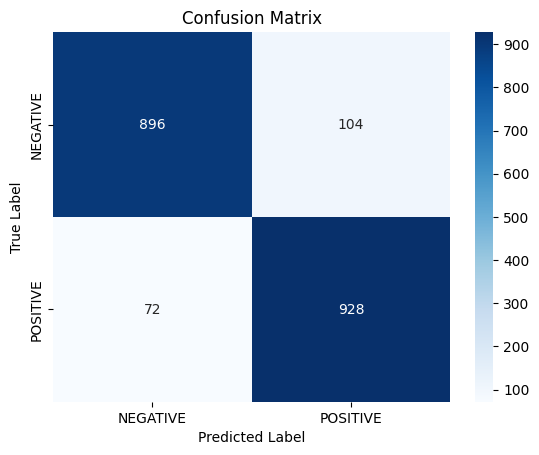

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/mamba_augmented/confusion_matrix.png'
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
cm = plot_confusion_matrix(y_true, y_pred, id2label, saving_path)
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

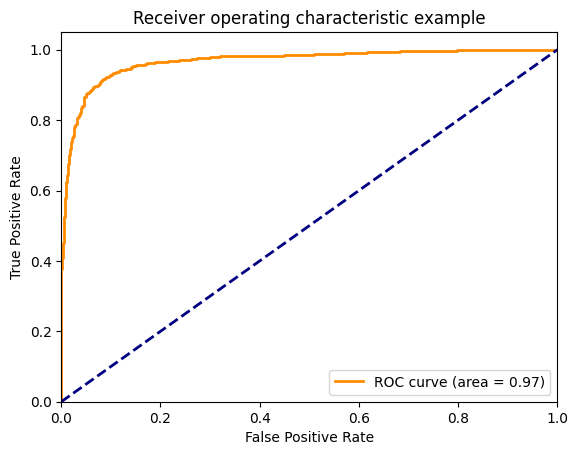

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/mamba_augmented/roc.curve.png'
plot_roc_curve(y_true, predictions, saving_path=saving_path)

In [ ]:
compute_metrics(y_pred, y_true)

{'accuracy': 0.912,
 'f1': 0.9133858267716536,
 'precision': 0.8992248062015504,
 'recall': 0.928}

## DistillBERT

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_tweet = augmented_tweet.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8400 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_tweet["train"]
eval_dataset = tokenized_tweet["eval"]
test_dataset = tokenized_tweet["test"]

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="distillbert_imbalanced",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    warmup_ratio=0.01,
    lr_scheduler_type="cosine",
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    logging_strategy="steps",
    logging_steps=1,
    push_to_hub=True,
    load_best_model_at_end=True,
)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
420,0.192200,0.255343,0.922381
840,2.582400,0.421414,0.902381
1260,0.017400,0.274029,0.926190
1680,0.094000,0.348117,0.919524
2100,0.003200,0.304943,0.931905
2520,0.002600,0.318772,0.930952
2940,0.000700,0.328075,0.929524
3360,0.000800,0.342727,0.930476
3780,0.007000,0.343516,0.931905
4200,0.002900,0.346190,0.931905


TrainOutput(global_step=4200, training_loss=0.25530977459613324, metrics={'train_runtime': 140.9573, 'train_samples_per_second': 119.185, 'train_steps_per_second': 29.796, 'total_flos': 137519788032864.0, 'train_loss': 0.25530977459613324, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

CommitInfo(commit_url='https://huggingface.co/erostrate9/distillbert_imbalanced/commit/dbc2562e12923c29639b76d072289143b79b9a0e', commit_message='Training complete', commit_description='', oid='dbc2562e12923c29639b76d072289143b79b9a0e', pr_url=None, pr_revision=None, pr_num=None)

### Testing

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/distillbert_augmented/'
outputs, y_pred, y_true = save_outputs(trainer, test_dataset, saving_path = saving_path)
outputs

PredictionOutput(predictions=array([[ 1.8897064 , -1.6371721 ],
       [ 0.84222215, -0.689308  ],
       [ 1.3949889 , -1.356257  ],
       ...,
       [-2.7116377 ,  3.5375397 ],
       [-2.669702  ,  3.453371  ],
       [-2.5171933 ,  3.2856789 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.31693702936172485, 'test_accuracy': 0.907, 'test_runtime': 1.0103, 'test_samples_per_second': 1979.662, 'test_steps_per_second': 123.729})

In [ ]:
predictions = np.load('/content/drive/MyDrive/csi5386-project/results/distillbert_augmented/predictions.npy')
y_pred = np.load('/content/drive/MyDrive/csi5386-project/results/distillbert_augmented/y_pred.npy')
y_true = np.load('/content/drive/MyDrive/csi5386-project/results/distillbert_augmented/y_true.npy')

(907, 93, 79, 921)

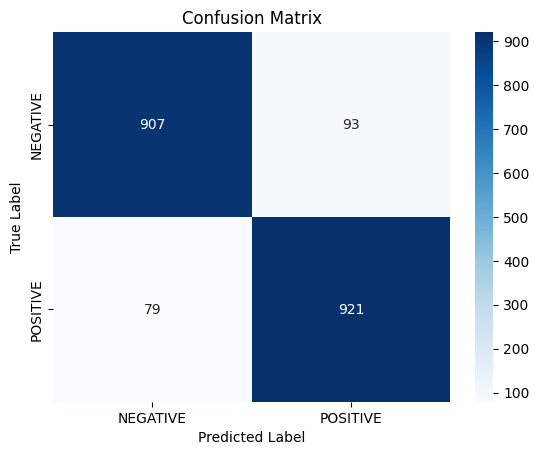

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/distillbert_augmented/confusion_matrix.png'
cm = plot_confusion_matrix(y_true, y_pred, id2label, saving_path)
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

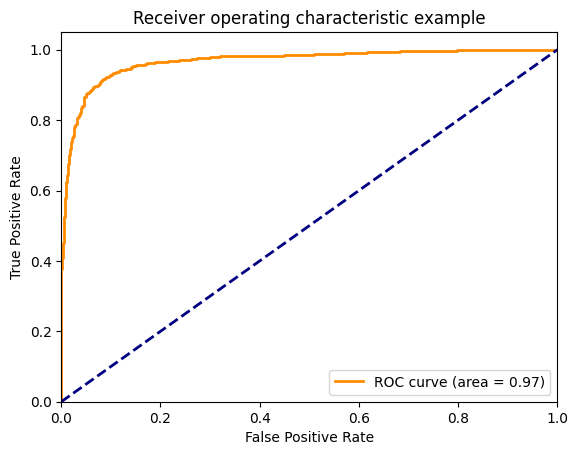

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/distillbert_augmented/roc.curve.png'
plot_roc_curve(y_true, outputs.predictions, saving_path=saving_path)

In [ ]:
compute_metrics(y_pred, y_true)

{'accuracy': 0.914,
 'f1': 0.9145978152929494,
 'precision': 0.908284023668639,
 'recall': 0.921}

In [ ]:
# ! mkdir /content/drive/MyDrive/csi5386-project/results/mamba_imbalanced
! cp -r results/mamba_imbalanced /content/drive/MyDrive/csi5386-project/results/

## Naive Bayes

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,  ConfusionMatrixDisplay

X_train = augmented_tweet['train']['text']
X_test = augmented_tweet['test']['text']
y_train = augmented_tweet['train']['label']
y_test = augmented_tweet['test']['label']

pipe = Pipeline([('tfidf_vectorizer',TfidfVectorizer(lowercase = True,
                                                     stop_words = 'english',
                                                    analyzer = 'word')),

                 ('naive_bayes', MultinomialNB())])


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

pipe.fit(list(X_train), list(y_train))
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_pred, y_test))
pipe['naive_bayes']

[[742 113]
 [258 887]]
0.8145


MultinomialNB()

(742, 258, 113, 887)

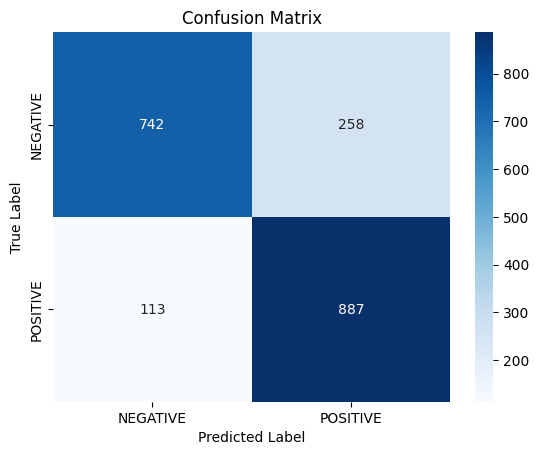

In [ ]:
saving_path = '/content/drive/MyDrive/csi5386-project/results/naive_bayes_augmented/confusion_matrix.png'
cm = plot_confusion_matrix(y_test, y_pred, id2label, saving_path)
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

In [ ]:
compute_metrics(y_pred, y_test)

{'accuracy': 0.8145,
 'f1': 0.8270396270396271,
 'precision': 0.7746724890829695,
 'recall': 0.887}

# Comparision

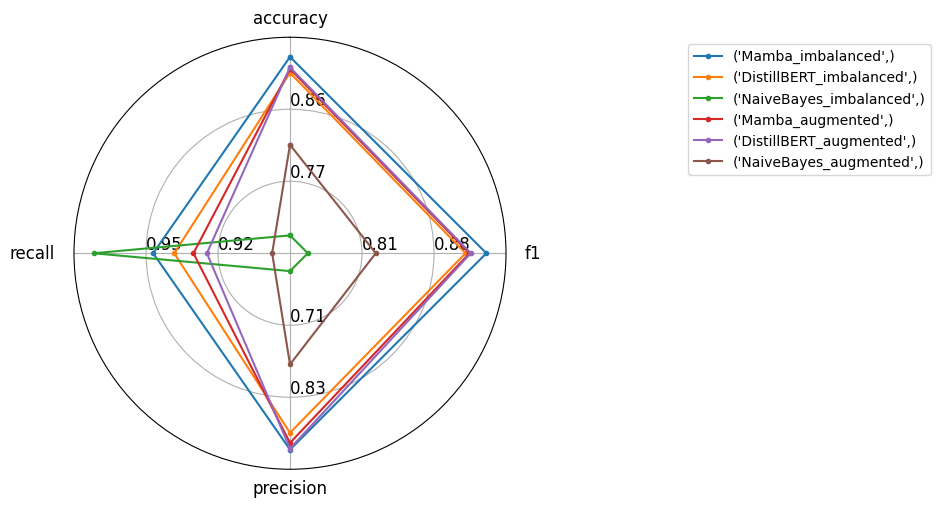

In [ ]:
import evaluate
from evaluate.visualization import radar_plot

data = [
    # Mamba_imbalanced
   {'accuracy': 0.9275,
 'f1': 0.9290259422418014,
 'precision': 0.909875359539789,
 'recall': 0.949},
  #  DistillBERT_imbalanced
  {'accuracy': 0.907,
 'f1': 0.909796314258002,
 'precision': 0.8832391713747646,
 'recall': 0.938},
  # NaiveBayes_imbalanced
   {'accuracy': 0.698,
 'f1': 0.764430577223089,
 'precision': 0.6265984654731458,
 'recall': 0.98},
  #  Mamba_augmented
   {'accuracy': 0.912,
 'f1': 0.9133858267716536,
 'precision': 0.8992248062015504,
 'recall': 0.928},
  #  DistillBERT_augmented
   {'accuracy': 0.914,
 'f1': 0.9145978152929494,
 'precision': 0.908284023668639,
 'recall': 0.921},
    # NaiveBayes_augmented
   {'accuracy': 0.8145,
 'f1': 0.8270396270396271,
 'precision': 0.7746724890829695,
 'recall': 0.887}
   ]
model_names = ["Mamba_imbalanced", "DistillBERT_imbalanced", 'NaiveBayes_imbalanced',
               'Mamba_augmented', 'DistillBERT_augmented', 'NaiveBayes_augmented']
plot = radar_plot(data=data, model_names=model_names)
plot.savefig('/content/drive/MyDrive/csi5386-project/results/comparision.png', bbox_inches='tight')